## Attractor Networks

### Problem 1: Ring Attractor Dynamics in Drosophila

#### Part A: Model Setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt

##### Network Architecture

##### Parameters

In [ ]:
N = 100          # Number of excitatory neurons (set in problem)
T = 1000         # Simulation time steps
dt = 0.1         # Time step size 

tau_exc = 60.0   # Excitatory time constant
tau_inh = 10.0   # Inhibitory time constant
beta = 5.0       # Sigmoid parameter
theta= 0.4       # Activation threshold

sigma = 8.0      # Width of excitatory connections
w_exc_amp = 2.0  # Strength of excitatory connections
w_inh = 2.0      # Global inhibition strength
w0 = 1.0         # Input to inhibitory neuron

##### Initialization

In [ ]:
# Initialize activities
r_exc = np.zeros((N, T))
r_inh = np.zeros(T)

# Create proper Gaussian weight matrix with periodic boundaries
dist = np.array([[min(abs(i-j), N-abs(i-j)) for j in range(N)] for i in range(N)])
w_exc = w_exc_amp * np.exp(-dist**2/(2*sigma**2))

# Sigmoid activation function
def F(x): 
    return 1 / (1 + np.exp(-beta*(x-theta)))

# Initial condition - Gaussian bump
center = N//2
width = 5
r_exc[center-width:center+width+1, 0] = np.exp(-np.linspace(-3, 3, 2*width+1)**2)

#### Part B: Stimulation

##### Part B.1: Stable Bump Attractor

In [4]:
# Simulation loop
for t in range(1, T):
    # Update inhibitory neuron (global inhibition)
    r_inh[t] = r_inh[t-1] + (dt/tau_inh)*(-r_inh[t-1] + F(w0*np.sum(r_exc[:,t-1])))
    
    # Vectorized update of excitatory neurons
    exc_input = w_exc @ r_exc[:,t-1] - w_inh*r_inh[t]
    r_exc[:,t] = r_exc[:,t-1] + (dt/tau_exc)*(-r_exc[:,t-1] + F(exc_input))

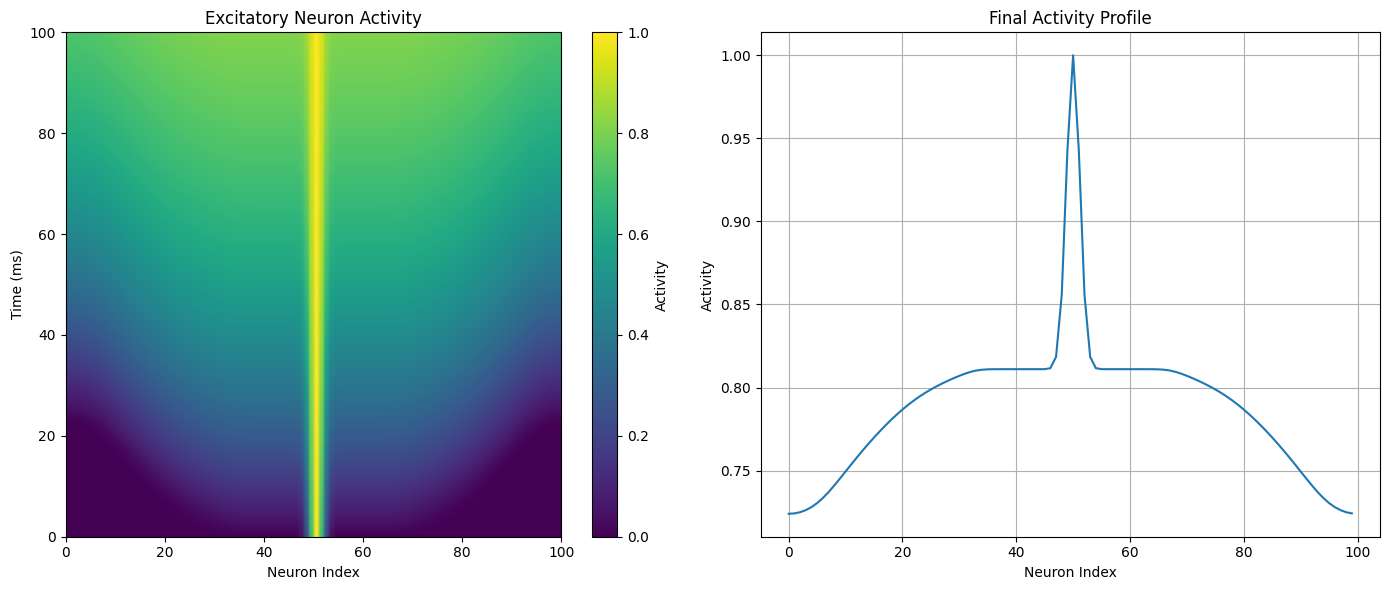

In [5]:
plt.figure(figsize=(14, 6))

# Space-time plot
plt.subplot(1, 2, 1)
plt.imshow(r_exc.T, aspect='auto', cmap='viridis', 
           extent=[0, N, 0, T*dt], origin='lower')
plt.colorbar(label='Activity')
plt.xlabel('Neuron Index')
plt.ylabel('Time (ms)')
plt.title('Excitatory Neuron Activity')

# Final activity profile
plt.subplot(1, 2, 2)
plt.plot(r_exc[:,-1])
plt.xlabel('Neuron Index')
plt.ylabel('Activity')
plt.title('Final Activity Profile')
plt.grid(True)

plt.tight_layout()
plt.show()


##### Part B.2: Stimulus-Driven Bump Formation

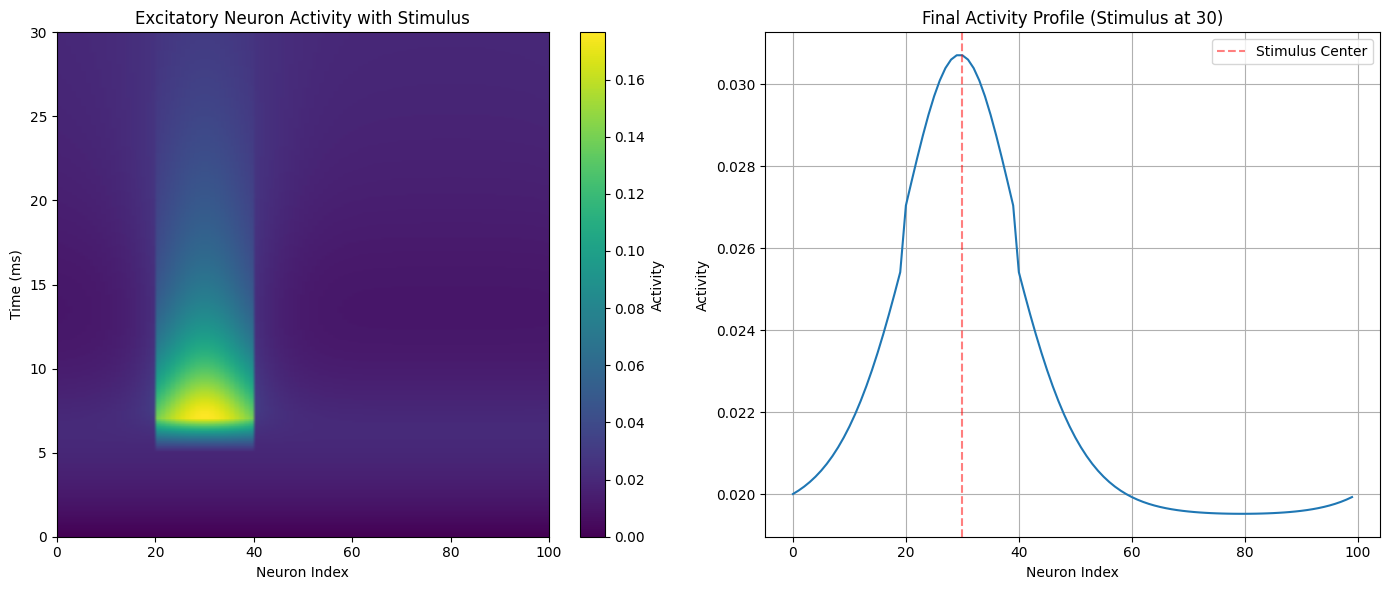

In [6]:
# Network parameters
N = 100  # Number of excitatory neurons
T = 300  # Total simulation time steps
dt = 0.1  # Time step size

# Time constants
tau_exc = 5  # Excitatory neuron time constant
tau_inh = 2  # Inhibitory neuron time constant

# Sigmoidal activation function
def F(z, beta=5, theta=0.7):
    return 1 / (1 + np.exp(-beta * (z - theta)))

# Connectivity parameters
A = 0.25  # Peak strength of local excitation
sigma_w = 8  # Width of local excitation kernel
winh = 1.2  # Strength of global inhibition
w0 = 0.15  # Weight to inhibitory neuron

# Initialize activities
r_exc = np.zeros((N, T))
r_inh = np.zeros(T)

# Generate weight matrix
i, j = np.meshgrid(np.arange(N), np.arange(N))
distance = np.minimum(np.abs(i-j), N-np.abs(i-j))
w_exc = A * np.exp(-distance**2 / (2 * sigma_w**2))

# Stimulus parameters
stim_center = 30          # Which neuron to stimulate
stim_strength = 0.5       # Stimulus intensity 
stim_start, stim_end = 50, 70  # Stimulus time window

# Create stimulus array
I = np.zeros((N, T))
I[stim_center-10:stim_center+10, stim_start:stim_end] = stim_strength

# Simulation loop
for t in range(1, T):
    # Update inhibitory neuron
    total_exc_input = np.sum(w0 * r_exc[:, t-1])
    r_inh[t] = r_inh[t-1] + (dt/tau_inh) * (-r_inh[t-1] + F(total_exc_input))
    
    # Update excitatory neurons with stimulus
    for i in range(N):
        local_excitation = np.dot(w_exc[i, :], r_exc[:, t-1])
        inhibition = winh * r_inh[t]
        r_exc[i, t] = r_exc[i, t-1] + (dt/tau_exc) * (-r_exc[i, t-1] + F(local_excitation + I[i, t-1] - inhibition))

# Visualization
plt.figure(figsize=(14, 6))

# Space-time plot
plt.subplot(1, 2, 1)
plt.imshow(r_exc.T, aspect='auto', cmap='viridis', 
           extent=[0, N, 0, T*dt], origin='lower')
plt.colorbar(label='Activity')
plt.xlabel('Neuron Index')
plt.ylabel('Time (ms)')
plt.title('Excitatory Neuron Activity with Stimulus')

# Final activity profile
plt.subplot(1, 2, 2)
plt.plot(r_exc[:,-1])
plt.xlabel('Neuron Index')
plt.ylabel('Activity')
plt.title(f'Final Activity Profile (Stimulus at {stim_center})')
plt.grid(True)

# Add stimulus indicator
plt.axvline(x=stim_center, color='r', linestyle='--', alpha=0.5, label='Stimulus Center')
plt.legend()

plt.tight_layout()
plt.show()

##### Part B.3: Parameter Exploration

The central inhibitory neuron plays a crucial stabilizing role in the ring attractor network through several mechanisms. By providing global feedback inhibition, it creates competition between excitatory neurons that prevents runaway excitation while maintaining localized activity. This inhibition balances the local excitatory connections, allowing the network to sustain a stable activity bump without either collapsing to zero activity or exploding to full saturation. The inhibitory neuron effectively normalizes the total network activity, with its strength (w_inh) determining the sharpness of the bump - stronger inhibition produces narrower, more focused bumps.

When the inhibitory connection strength (w_inh) is set to zero, the network loses this critical competitive mechanism. Without global inhibition, the local excitatory connections cause activity to spread uncontrollably across the entire ring, resulting in a uniform high-activity state rather than a localized bump. Conversely, if the input to the inhibitory neuron (w0) is zero, the inhibitory neuron becomes non-functional as it receives no excitatory input, leading to similar uncontrolled excitation as with w_inh=0.

The network typically cannot support multiple stable bumps simultaneously due to the global nature of the inhibition. The winner-takes-all dynamics imposed by the inhibitory neuron suppress all potential bumps except the strongest one. While multiple bumps might transiently appear under certain conditions (such as with very wide excitation kernels or weak inhibition), they quickly collapse into a single stable bump. This property makes the network particularly suitable for representing single-valued variables like head direction.

Several factors can cause the bump to become unstable. Drift (gradual movement of the bump position) occurs when there are asymmetries in the excitation kernel or when noise levels are high relative to the bump's stability. Dissipation (loss of the bump) happens under conditions of excessive inhibition, insufficient excitation, or mismatched time constants between excitatory and inhibitory populations. The network's stability depends critically on the balance between local excitation (controlled by A and σ_w) and global inhibition (controlled by w_inh and w0), with optimal performance occurring within a specific parameter range that maintains persistent yet localized activity.



### Problem 2: Transition to Chaos in Random Nueral Networks